<a href="https://colab.research.google.com/github/EzpieCo/PyTorch-Crash-Course/blob/main/03-pytorch-binary-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 Binary Classification with PyTorch

GitHub repository: https://github.com/EzpieCo/PyTorch-Crash-Course

Crash Course: https://ezpie.vercel.app/courses/machine-learning

In case of an question: https://github.com/EzpieCo/PyTorch-Crash-Course/discussions

---

In Binary classification our main objective is to predict weather a given value is one thing or another, ex. is it spam or not spam? Is it a cat or a dog?

## Chapter: Creating a dataset for binary classification

In order to classify any data, we first need some data!

To do this we will use sklearn, another fun library for machine learning(well they did said python is for machine learning not backend).

We will use the [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method from `sklearn.datasets` to make our dataset of 2 different types of classes.

In [1]:
#@title importing the dependencies

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

torch.__version__ # Just to check

'2.0.1+cu118'

In [2]:
#@title Create data of two classes(two different values)
X, y = make_blobs(n_samples=1000,
                            n_features=2, # number of features, here we have the x and y(x2 more like) as features
                            centers=2, # number of classes
                            cluster_std=1.5, # some randomness in data
                            random_state=42)

In [3]:
#@title Convert X and y into torch data type of float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [4]:
#@title Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

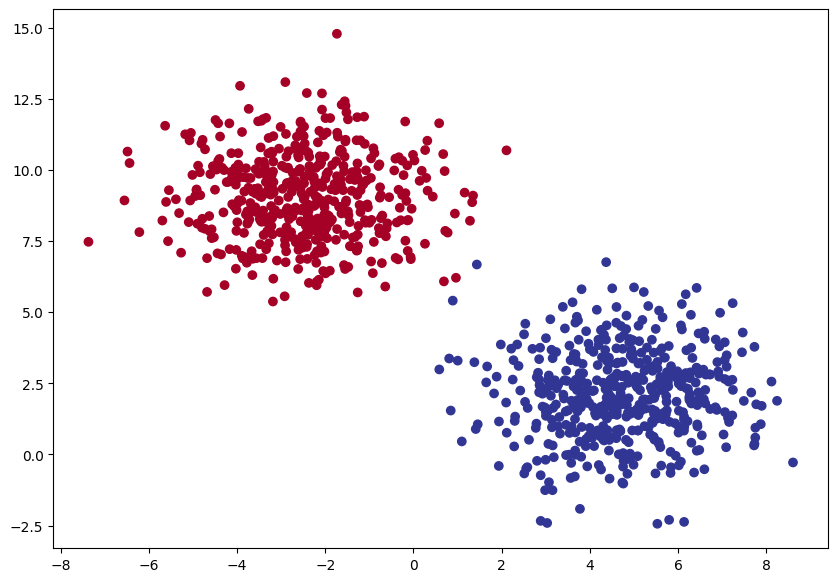

In [5]:
#@title Plot data for better visulization
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], # first feature - x1
            X[:, 1], # second feature - x2
            c=y, cmap=plt.cm.RdYlBu) # color the output

In [6]:
#@title setup device agnostic

# Create device agnostic
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Chapter: Creating the model

Now we will create the model that can learn patterns in our dataset.

In [7]:
#@title creating the model

from torch import nn

class BlobClassification(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 10)
    self.layer2 = nn.Linear(10, 1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model1 = BlobClassification().to(device)
model1

BlobClassification(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
#@title faster way of making a neural network

model2 = nn.Sequential(
    nn.Linear(2, 8),
    nn.Linear(8, 1)
).to(device)

model2

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

## Chapter: Picking loss function and creating training loop

Our data has 2 options for us - red or blue - Therefore our loss function will also be a bit different, apart from this, it can be used the same way as the MAE/L1 loss function.

Our data has 2 outputs of options - red or blue - So we need to check what kind of loss function will we need, in fact we only need the loss function the optimizer can stay the same.

If you check the pytorch documetation you will find 2 types of loss function with same names - BCELoss and BCEWithLogitLoss.

BCELoss - https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss

BCEWithLogitLoss - https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss

We will take BCEWithLogitLoss as it has sigmoid activation(explained in the course)

In [9]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # Has the sigmoid activation function

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)

### Raw Logits -> Prediction probabilities -> Predictions labels

The output of our model won't be 1s or 0s like our _y labels_ but raw logits and we have to convert them into 1s and 0s like our _y labels_.

To do so we will pass the raw logits into an activation function, sigmoid in binary classification and softmix in multi classification, thus converting them from **raw logits into Prediction probabilities**.

Then we will round off and we will get the values as 1s and 0s, thus converting **Prediction probabilities into prediction lables**.

In [10]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [11]:
#@title Pridicting raw logits

# First let's get the raw logits from our model

with torch.inference_mode():
  y_labels = model1(X_test).squeeze()

y_labels[:5]

tensor([0.0029, 0.2014, 0.1038, 0.0110, 0.2057])

In [12]:
#@title Turn raw logits into probabilities

# the sigmoid activation function converts the raw logits into probabilities
y_probs = torch.sigmoid(y_labels)

y_probs[:5]

tensor([0.5007, 0.5502, 0.5259, 0.5028, 0.5512])

In [13]:
#@title Turn probabilities into labels(1 or 0)

# Round off to be exact

y_preds = torch.round(y_probs)

y_preds[:5]

tensor([1., 1., 1., 1., 1.])

In [14]:
y_test[:5] # Model not trained, therefore the prdiction is bad

tensor([1., 0., 1., 1., 0.])

In [15]:
#@title Building the training loop

# Manual seed setting
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data to device(cuda)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

def trainer(epochs=100):
  for epoch in range(epochs):
    model1.train()

    # Forward pass
    y_logits = model1(X_train).squeeze()
    # y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calculate accuracy
    loss = loss_fn(y_logits, y_train)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Gradient descent
    optimizer.step()

    model1.eval()
    with torch.inference_mode():
      # Forward pass
      test_logits = model1(X_test).squeeze()
      # test_pred = torch.round(torch.sigmoid(test_logits))

      # Calculate loss
      test_loss = loss_fn(test_logits, y_test)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

trainer()


Epoch: 0 | Train Loss: 0.72748 | Test Loss: 0.26738
Epoch: 10 | Train Loss: 0.06119 | Test Loss: 0.04717
Epoch: 20 | Train Loss: 0.03718 | Test Loss: 0.02668
Epoch: 30 | Train Loss: 0.02840 | Test Loss: 0.01886
Epoch: 40 | Train Loss: 0.02378 | Test Loss: 0.01470
Epoch: 50 | Train Loss: 0.02090 | Test Loss: 0.01210
Epoch: 60 | Train Loss: 0.01892 | Test Loss: 0.01032
Epoch: 70 | Train Loss: 0.01746 | Test Loss: 0.00902
Epoch: 80 | Train Loss: 0.01633 | Test Loss: 0.00803
Epoch: 90 | Train Loss: 0.01543 | Test Loss: 0.00725


In [16]:
# With the loss of training and testing being near 0, now we can predict better

model1.eval()
with torch.inference_mode():
  y_logits = model1(X_test).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

print(f'Predictions: {y_preds[:5]}\n Labels: {y_test[:5]}')

Predictions: tensor([1., 0., 1., 1., 0.])
 Labels: tensor([1., 0., 1., 1., 0.])
